In [148]:
import pandas as pd
import pandas as pd
import numpy as np
import sys

%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()

import calculate_cleavage_rate as clv
reload(clv)

sys.path.append('../code_general_Finkelsteinlab')
import plotting_Finkelsteinlab as pltData
reload(pltData);

import Nucleaseq_data_processing as processing
reload(processing)

sys.path.append('../code_Boyle')
import plotting_Boyle as plt_B
reload(plt_B)
import CRISPR_dCas9_binding_curve_Boyle as dCas9
reload(dCas9)

sys.path.append('../code_general/')
import CRISPR_free_energy_landscape as FreeEnergy

In [ ]:
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
filename_data = 'ECas9_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'

In [31]:
fit_folder = '13_3_2019'
path = '../fits_Stijn/'+fit_folder+'/'
fit_num = 29

ch_sqs = []
fit_ids = np.arange(1,fit_num+1)
for fit_id in fit_ids:
    filename = 'fit_'+fit_folder+'_sim_'+str(fit_id)+'.txt'
    data = pd.read_table(path+filename,index_col=False)
    ch_sq = data['Potential'].iloc[-1]
    ch_sqs.append(ch_sq)

ch_sqs = np.array(ch_sqs)
best_fit_id = fit_ids[np.argmin(ch_sqs)]    
filename = 'fit_'+fit_folder+'_sim_'+str(best_fit_id)+'.txt'    
data = pd.read_table(path+filename,index_col=False)
parameters = data.iloc[-1].values[0:-2]

In [67]:
model_ID = 'Clv_Saturated_general_energies_v2'
guide = 20
k = np.zeros(20)
for i in range(1,guide+1):
    mismatch = [i]
    k[i-1] = clv.calc_clv_rate_fast(parameters,model_ID,mismatch,guide)
    
k_matrix = np.zeros([20,20])

for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_matrix[i-1,j-1] = np.log10(clv.calc_clv_rate_fast(parameters,model_ID,mismatch_positions,guide))
np.fill_diagonal(k_matrix,np.nan)
k_df = pd.DataFrame(k_matrix, index=range(1, 21), columns=range(1, 21))

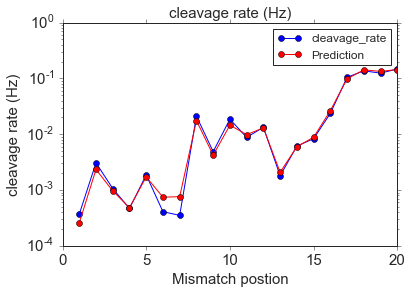

In [55]:
data_exp = pd.read_csv(path_to_data + filename_data)
plt.figure()
_=pltData.plot_single_mut_data(data_exp, 'cleavage_rate', 'r', Plot=True, logplot=True,data_name='cleavage rate (Hz)')
plt.semilogy(range(1,21),k, marker='o', linewidth=1, color='red', label='Prediction')
plt.legend()

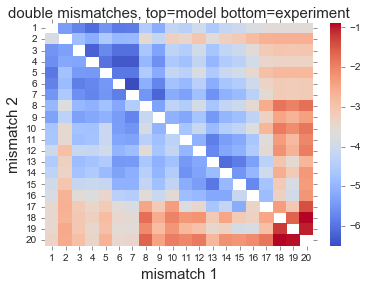

In [68]:
_, k_matrix_experiment = pltData.plot_double_mut_data(data_exp, 'cleavage_rate', 'r', Canonical=True, Ng=20, data_name='cleavage rate (Hz)', Plot=False, logplot=True,
                        SaveFigures=False, figure_name='./Figure.pdf')
k_matrix_experiment.fillna(0, inplace=True)
combined_df_median = k_df + k_matrix_experiment
sns.heatmap(combined_df_median, cmap='coolwarm', cbar=True)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)
plt.title('double mismatches, top=model bottom=experiment', fontsize=15)

In [181]:
parameters_binding = np.copy(parameters[0:-1])
parameters_binding = np.append(np.array(1.45), parameters_binding)
parameters_binding = np.append(parameters_binding, parameters_binding[-1])
parameters_binding = np.append(parameters_binding, parameters_binding[-1])
parameters_binding[-3] = -1.0
parameters_binding[0] = 1.0
parameters_binding = parameters_binding.astype(float)

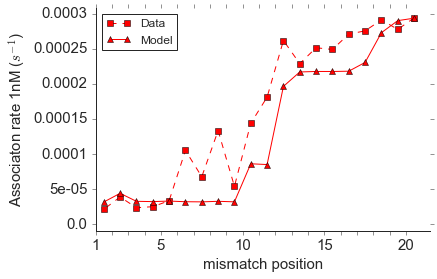

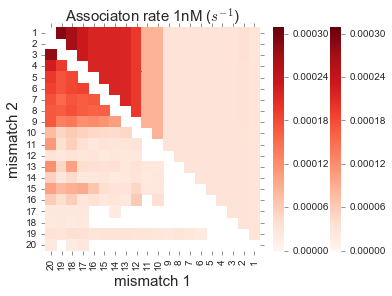

In [182]:
model_id = 'init_limit_general_energies_v2'
Model_pbound, Model_on, Model_off = plt_B.calc_predictions(parameters_binding,model_id)

plt.figure()
_,_ = plt_B.plot_single_mismatches(Model_on ,kind='OnRate')
plt.figure()
_,_ = plt_B.plot_heatmap(Model_on ,kind='OnRate')

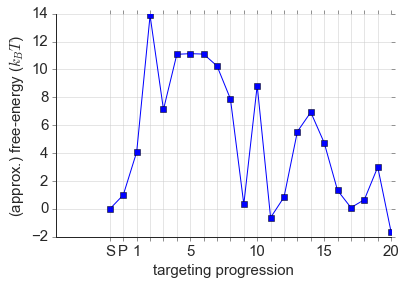

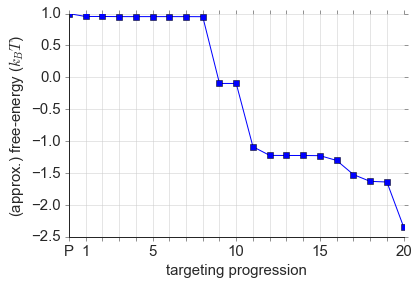

In [144]:
Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters_binding,model_id);

In [170]:
def calc_bound_fraction(parameters, mismatch_positions, timepoints=[500.,1000.,1500.],guide_length=20,rel_concentration=0.1):
    '''
    Association experiment for the effective on-rate:
    (repeating the protocol as used in Boyle et al.)
    :return:
    '''
    rate_matrix = dCas9.get_master_equation(parameters, mismatch_positions, model_id, guide_length)

    #1) Calculate bound fraction for specified time points:
    # Association experiment starts with all dCas9 being unbound:
    everything_unbound = np.array([1.0] + [0.0] * (guide_length + 1))

    #3) Association rate is taken at 1nM the other data at 10nM --> adjust k_on appropriatly:
    new_rate_matrix = rate_matrix.copy()
    new_rate_matrix[0][0] *= rel_concentration  #rel_concentration=1 corresponds to 10nM
    new_rate_matrix[1][0] *= rel_concentration

    bound_fraction = []
    for time in timepoints:
        Probabilities = dCas9.get_Probability(rate_matrix=new_rate_matrix,initial_condition=everything_unbound,T=time)
        bound_fraction.append( np.sum(Probabilities[1:]))
    return bound_fraction


In [183]:
timepoints = np.arange(0,1000,0.1)
bound_fraction_OT = calc_bound_fraction(parameters_binding, [], timepoints=timepoints)
bound_fraction_1mm = calc_bound_fraction(parameters_binding, [1], timepoints=timepoints)

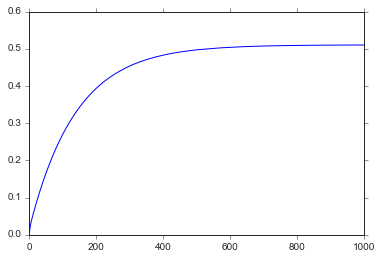

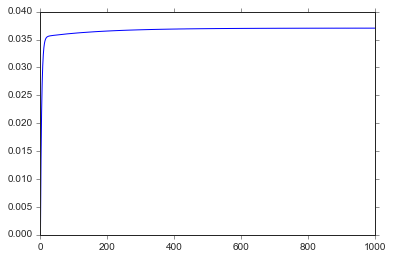

In [184]:
plt.figure()
plt.plot(timepoints, bound_fraction_OT, 'b-')
plt.figure()
plt.plot(timepoints, bound_fraction_1mm, 'b-')